In [9]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('broadway_original.webp')

In [10]:
def compute_energy(image):
    """
    Compute the energy of an image using the Sobel operator.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert to grayscale
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5) # Sobel operator in x direction
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5) # Sobel operator in y direction
    # Compute the energy map as the sum of the absolute values of the gradients
    # The Sobel operator returns floating point values, so we need to convert them to uint8
    energy = np.abs(sobel_x) + np.abs(sobel_y)
    return energy.astype(np.uint8)

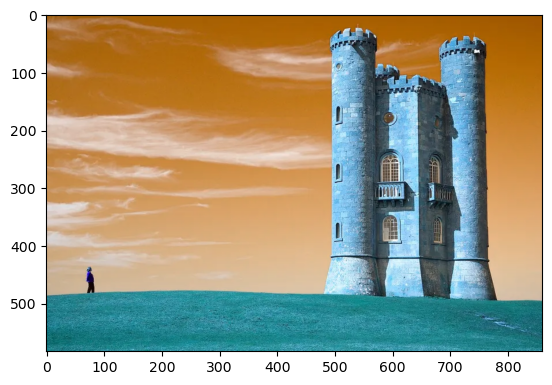

In [11]:
#show the original image
plt.imshow(image)

In [12]:
def find_seam(image):
    """
    Find the seam with the lowest energy in the image.
    """
    energy = compute_energy(image) # Compute the energy of the image
    rows, cols = energy.shape # Get the dimensions of the image
    seam = np.zeros((rows,), dtype=int) # Initialize the seam array
    dp = np.zeros((rows, cols), dtype=np.float32) # Initialize the dynamic programming table

    dp[0] = energy[0] # The first row is just the energy of the first row

    for i in range(1, rows):
        for j in range(cols):
            if j == 0:
                dp[i][j] = energy[i][j] + min(dp[i-1][j], dp[i-1][j+1])
            elif j == cols - 1:
                dp[i][j] = energy[i][j] + min(dp[i-1][j-1], dp[i-1][j])
            else:
                dp[i][j] = energy[i][j] + min(dp[i-1][j-1], dp[i-1][j], dp[i-1][j+1])

    seam[-1] = np.argmin(dp[-1]) # The last element of the seam is the column with the minimum value in the last row of dp

    for i in range(rows - 2, -1, -1):
        j = seam[i + 1]
        if j == 0:
            seam[i] = j if dp[i][j] < dp[i][j + 1] else j + 1
        elif j == cols - 1:
            seam[i] = j if dp[i][j] < dp[i][j - 1] else j - 1
        else:
            seam[i] = j if dp[i][j] < min(dp[i][j - 1], dp[i][j + 1]) else (j - 1 if dp[i][j - 1] < dp[i][j + 1] else j + 1)

    return seam

In [13]:
def remove_seam(image, seam):
    """
    Remove the seam from the image.
    """
    rows, cols, _ = image.shape # Get the dimensions of the image
    new_image = np.zeros((rows, cols - 1, 3), dtype=image.dtype) # Create a new image with one less column

    for i in range(rows):
        j = seam[i]
        new_image[i, :j] = image[i, :j] # Copy the pixels to the left of the seam
        new_image[i, j:] = image[i, j + 1:] # Copy the pixels to the right of the seam

    return new_image

In [14]:
# Main function to run the seam carving algorithm
def seam_carving(image, num_seams):
    """
    Perform seam carving on the image.
    """
    for _ in range(num_seams):
        seam = find_seam(image) # Find the seam with the lowest energy
        image = remove_seam(image, seam) # Remove the seam from the image
    return image

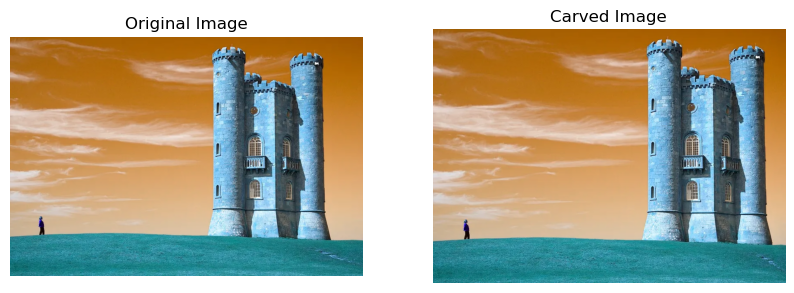

In [16]:
#test the seam carving algorithm
num_seams = 50 # Number of seams to remove
carved_image = seam_carving(image, num_seams) # Perform seam carving
# Display the original and carved images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(carved_image)
plt.title('Carved Image')
plt.axis('off')
plt.show() # Show the images


